In [1]:
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf 
from tqdm import tqdm
from tensorflow.keras import optimizers

import sklearn
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [2]:
def get_accuracy(labs, pred_labs):
    tp = 0
    for i in range(len(labs)):
        if labs[i]==pred_labs[i]:
            tp = tp+1
            
    return tp*(100/len(labs))

In [3]:
path = r'D:\Breast cancer material\MIAS_Preprocess\mias_preprocess_Part1\original\train'
folders=glob.glob(os.path.join(path,'*'))
label=[]
i=0
imgs=[]
for fol in folders:
    files=glob.glob(os.path.join(fol,'*'))
    for image in files:
        im=cv2.imread(image)
        im= cv2.resize(im,(160,160))/255
        imgs.append(im)
        label.append(i)
    i=i+1
imgs=np.array(imgs)
label=np.array(label)
imgs,label=shuffle(imgs,label)

In [4]:
labs = np.zeros((label.size, label.max()+1))
labs[np.arange(label.size),label] = 1

In [5]:
img_val = imgs[100:110, :, :,:]
labs_val = labs[100:110,:]


((10, 160, 160, 3), (10, 3))

((308, 160, 160, 3), (308, 3))

In [7]:
path = r'D:\Breast cancer material\MIAS_Preprocess\mias_preprocess_Part1\original\test'
folders=glob.glob(os.path.join(path,'*'))
label_test=[]
i=0
imgs_test=[]
for fol in tqdm(folders):
    files=glob.glob(os.path.join(fol,'*'))
    for image in tqdm(files):
        im=cv2.imread(image)
        im= cv2.resize(im,(160,160))/255
        imgs_test.append(im)
        label_test.append(i)
    i=i+1
    
imgs_test=np.array(imgs_test)
label_test=np.array(label_test)
imgs_test,label_test=shuffle(imgs_test,label_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1638.61it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1671.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 77.04it/s]


In [8]:
b = np.zeros((label.size, label.max()+1))
b[np.arange(label.size),label] = 1
b[100]

array([0., 0., 1.])

In [9]:
model = tf.keras.applications.DenseNet121(
    include_top=True,
    weights= None,
    input_tensor=None,
    input_shape=(160,160, 3),
    pooling=None,
    classes=3
)
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 80, 80, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [10]:
from tensorflow.keras import optimizers
optimizer=optimizers.SGD(lr=0.01, momentum=0.9)
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
#               optimizer=optimizer,
              metrics=['accuracy'])

C:\Users\Umar\anaconda3\envs\keras\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [11]:
batch_size = 8

In [12]:
import tensorflow.keras.callbacks as callbacks
model_path = 'DenseNet121.h5'
model_check_points = callbacks.ModelCheckpoint(filepath= model_path, monitor='val_loss', verbose=0, save_best_only=True,
                                                save_weights_only=False, mode='auto', save_freq='epoch',
                                                options=None)
ES = callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False )
monitor = 'categorical_accuracy'
# reduce_lr = callbacks.ReduceLROnPlateau(monitor=monitor, patience=3)


In [17]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)
history =  model.fit(imgs,labs, validation_data=(img_val, labs_val), epochs=50, batch_size = batch_size,
                     callbacks = [model_check_points])

Epoch 1/50
39/39 [==============================] - 17s 429ms/step - loss: 0.2261 - accuracy: 0.9156 - val_loss: 0.9868 - val_accuracy: 0.5000
Epoch 2/50
39/39 [==============================] - 17s 426ms/step - loss: 0.1186 - accuracy: 0.9740 - val_loss: 0.2582 - val_accuracy: 0.9000
Epoch 3/50
39/39 [==============================] - 17s 428ms/step - loss: 0.1965 - accuracy: 0.9286 - val_loss: 1.1709 - val_accuracy: 0.8000
Epoch 4/50
39/39 [==============================] - 17s 425ms/step - loss: 0.1693 - accuracy: 0.9578 - val_loss: 0.7411 - val_accuracy: 0.8000
Epoch 5/50
39/39 [==============================] - 17s 434ms/step - loss: 0.1513 - accuracy: 0.9481 - val_loss: 2.1832 - val_accuracy: 0.4000
Epoch 6/50
39/39 [==============================] - 17s 427ms/step - loss: 0.1892 - accuracy: 0.9286 - val_loss: 0.1647 - val_accuracy: 1.0000
Epoch 7/50
39/39 [==============================] - 17s 424ms/step - loss: 0.1222 - accuracy: 0.9610 - val_loss: 0.5026 - val_accuracy: 0.8000

In [31]:
model.load_weights('DenseNet121.h5')
pred_labs = []
for i in range(len(label_test)):
    img =  imgs_test[i,:, :, :]
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = pred.argmax(axis=1)
    pred_labs.append(pred[0])
    
pred_labs=np.array(pred_labs)

In [32]:
imgs_test.max()

0.9882352941176471

In [33]:
pred_labs = pred_labs+10
pred_labs = np.where(pred_labs==12,0, pred_labs)
pred_labs = np.where(pred_labs==11,2, pred_labs)
pred_labs = np.where(pred_labs==10,1, pred_labs)

label_test = label_test+10
label_test = np.where(label_test==12,0, label_test)
label_test = np.where(label_test==11,2, label_test)
label_test = np.where(label_test==10,1, label_test)

print('Accuracy is: ', get_accuracy(label_test, pred_labs))

Accuracy is:  83.33333333333334


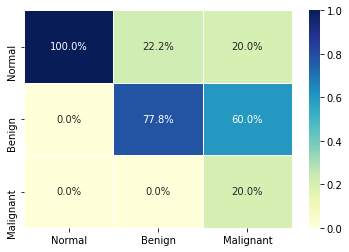

In [34]:
array = sklearn.metrics.confusion_matrix(pred_labs, label_test)
array = array / array.astype(np.float).sum(axis=0)
ax = sn.heatmap(array,annot=True,cmap="YlGnBu", linewidth=0.5,fmt=".1%",xticklabels=['Normal','Benign','Malignant'], yticklabels=['Normal','Benign','Malignant'])

figure = ax.get_figure()
figure.savefig('DenseNet121.png', dpi=1200)